In [1]:
import math
import pandas as pd
import numpy as np
import numpy
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
data_NSE = yf.download("^NSEI", start="2013-05-01", end="2023-05-01", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [9]:
from scipy.signal import argrelextrema

def refine_data(series_data, smooth=10):
    smooth_data = series_data.rolling(window = smooth).mean().dropna()

    # Finding Local Maxima, Minimas which are extremely helpful in finding chart patterns
    local_max = argrelextrema(smooth_data.values, np.greater)[0]
    local_min = argrelextrema(smooth_data.values, np.less)[0]

    return smooth_data, local_max, local_min

**Rounding Top**

In [3]:
def rounding_top(data_Close, window=100):
    pattern = []

    for i in range(0, len(data_Close)-100, 100):
        data = data_Close[i: i+100]

        # PolyFit
        x = np.linspace(1, len(data), len(data))
        pol = np.polyfit(x, data, np.sqrt(len(data))*2)
        y_pol = np.polyval(pol, x)

        # Getting all Local minimas using prev thing
        smooth_data, local_max, local_min = refine_data(pd.Series(y_pol), 5)
        data = data[len(data) - len(smooth_data): ]
        for x in local_max:
            pattern.append(data.index[x])

    return pattern

<ipython-input-10-8013416d030a>:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
<ipython-input-10-8013416d030a>:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
<ipython-input-10-8013416d030a>:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
<ipython-input-10-8013416d030a>:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
<ipython-input-10-8013416d030a>:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
<ipython-input-10-8013416d030a>:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
<ipython-input-10-8013416d030a>:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
<ipython-input-10-8013416d030a>:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_t

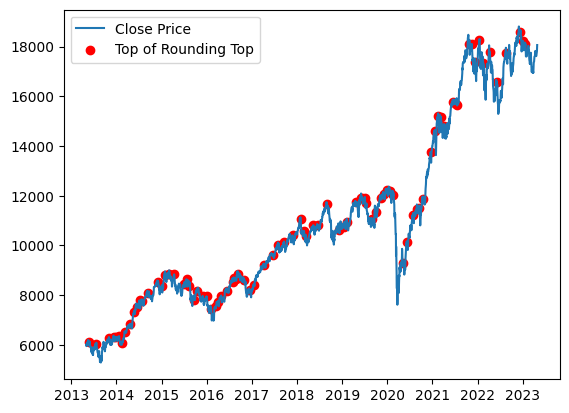

In [10]:
rb_ptrn = rounding_top(data_NSE.Close, 200)

plt.plot(data_NSE.index, data_NSE.Close)
plt.scatter(rb_ptrn, data_NSE.Close[rb_ptrn], color='red')
plt.legend(["Close Price", "Top of Rounding Top"])

**Head and Shoulders**

In [4]:
def head_and_shoulders(data_Close, pct_change=0.01, head_pct=0.012):
    smooth_data, local_max, local_min = refine_data(data_Close, 5)
    if (local_max[0] > local_min[0]):
        local_min = np.delete(local_min, 0)
    else:
        local_min = np.delete(local_min, len(local_min) - 1)

    local_min = smooth_data[local_min]
    local_max = smooth_data[local_max]

    heads = []
    shoulders = []
    for i in range(2, min(len(local_max), len(local_min))):
        if (local_max[i] < local_max[i-2]*(1+pct_change) and local_max[i] > local_max[i-2]*(1-pct_change)) and (local_max[i-1] > local_max[i]*(1+head_pct) or local_max[i-1] > local_max[i-2]*(1+head_pct)):
            heads.append(local_max.index[i-1])
            shoulders.append(local_max.index[i-2])
            shoulders.append(local_max.index[i])

    return heads, shoulders

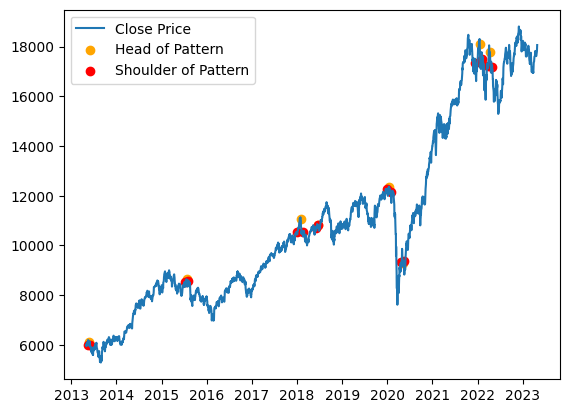

In [11]:
head, shoulder = head_and_shoulders(data_NSE.Close, 0.01, 0.01)

plt.plot(data_NSE.index, data_NSE.Close)
plt.scatter(head, data_NSE.Close[head], color='orange')
plt.scatter(shoulder, data_NSE.Close[shoulder], color='red')
plt.legend(["Close Price", "Head of Pattern", "Shoulder of Pattern"])

**Cup and Handle**

In [5]:
def cup_and_handle(data_Close):
    data, local_max, local_min = refine_data(data_Close, 5)
    extremes = np.concatenate((local_min, local_max))
    extremes.sort()

    offset = 0.2
    mid_peak_threshold_up = 0.65
    mid_peak_threshold_down = 0.2
    min_handle_threshold = 0.05
    max_handle_threshold = 0.7
    buy_offset = 0.1
    stoploss = 0.25

    a = 0
    flag = 0
    cup = []
    buy_sell = []
    profit = 0

    for i_ex in range(0, len(extremes)):
        i = extremes[i_ex]
        i_min = extremes[i_ex]
        flag = 0
        all_points = []
        for a,x in enumerate(extremes[i_ex:]):
            if data[x] > data[i]:
                break
            if data[x] < data[i_min]:
                i_min = x

            if (a < (len(extremes[i_ex:])-1)) and (a>0):
                if (data[x] > (data[i_min] + (data[i] - data[i_min])*mid_peak_threshold_up)):
                    flag = 1
                    break
            all_points.append(x)


        i_max = x
        if data[i_max] > (data[i] + (data[i] - data[i_min])*offset):
            continue
        if flag:
            continue

        try:
            p1 = extremes[i_ex:][a+1]
        except:
            continue

        for x in extremes[(i_ex+a):]:
            if data[x] > (data[i_max] + (data[i_max] - data[i_min])*buy_offset):
                p2 = x
                break
            if data[x] < data[p1]:
                p1 = x



        if (data[p1] > data[i_min]) and (data[p2] > data[i_max]) and (i != i_min):
            cup.append([i, i_min, i_max, p1, p2])

            buy_idx = -1
            buy_price = -1
            sell_idx = -1
            sell_price = -1
            for d, x in enumerate(data[p1:]):
                if (x > (data[i_max] + (data[i_max] - data[i_min])*buy_offset)):
                    buy_idx = d+p1
                    buy_price = x
                    break

            maxx = data[p2]
            idx = np.where(extremes==p2)[0][0]
            for e, x in enumerate(extremes[idx:]):
                if (e>0):
                    if (data[x] > maxx):
                        maxx = data[x]
                    if (data[x] < data[extremes[idx:][e-1]]):
                        loss = data[extremes[idx:][e-1]] - data[x]
                        if (loss > stoploss*(maxx - buy_price)):
                            break

            for f, x in enumerate(data[extremes[idx:][e-1]:]):
                loss = data[extremes[idx:][e-1]] - x
                if (loss > stoploss*(maxx - buy_price)):
                    sell_idx = f + extremes[idx:][e-1]
                    sell_price = x
                    break

            buy_sell.append([buy_idx, sell_idx])
            profit += (sell_price - buy_price)

    return cup, data, buy_sell, profit


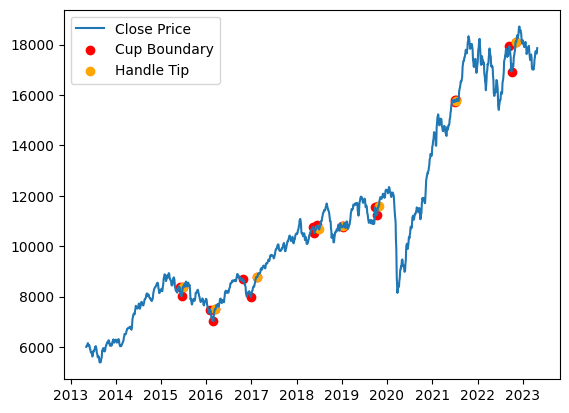

In [13]:
cup, data, _, __ = cup_and_handle(data_NSE.Close)
plt.plot(data.index, data)

for x in cup:
    plt.scatter(data.index[x[0:3]], data[x[0:3]], color='red')
    plt.scatter(data.index[x[3:4]], data[x[3:4]], color='orange')
plt.legend(["Close Price", "Cup Boundary", "Handle Tip"])

**Bear Flag**

In [6]:
def bear_flag(data_Close, pct_change=0.05):
    smooth_data, local_max, local_min = refine_data(data_Close, 5)
    if (local_max[0] > local_min[0]):
        local_max = np.delete(local_max, len(local_max) - 1)
    else:
        local_max = np.delete(local_max, 0)

    extremes = np.concatenate((local_min, local_max))
    extremes.sort()
    extremes = smooth_data[extremes]

    pattern = 0
    flag = []
    for i in range(2, len(extremes), 2):
        if (extremes[i-2] < extremes[i]*(1+pct_change) and extremes[i-2] > extremes[i]*(1-pct_change)) and (extremes[i-1] < extremes[i+1]*(1+pct_change) and extremes[i-1] > extremes[i+1]*(1-pct_change)):
            if pattern == 0:
                flag.append([extremes.index[i-2], extremes.index[i-1]])
                pattern = 1
        else:
            if pattern == 1:
                flag[-1].append(extremes.index[i-2])
                flag[-1].append(extremes.index[i-1])
                pattern = 0

    if len(flag[-1]) == 2:
        flag.remove(flag[-1])

    return flag, smooth_data

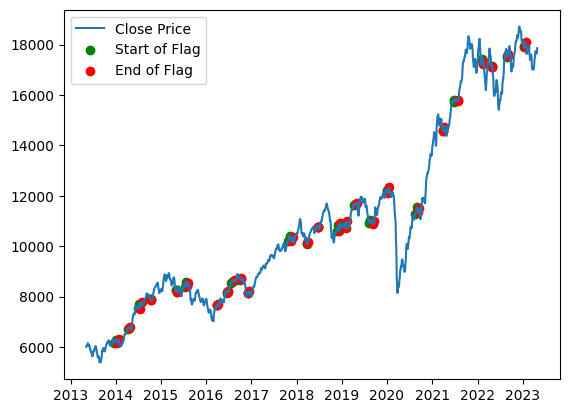

In [12]:
flags, data = bear_flag(data_NSE.Close, 0.01)
plt.plot(data.index, data)

for x in flags:
    plt.scatter(x[0:2], data[x[0:2]], color='green')
    plt.scatter(x[2:], data[x[2:]], color='red')
plt.legend(["Close Price", "Start of Flag", "End of Flag"])

**Ascending Triangle**

In [7]:
def ascending_triangle(data_Close, pct_change=0.05):
    smooth_data, local_max, local_min = refine_data(data_Close, 5)
    if (local_max[0] > local_min[0]):
        local_max = np.delete(local_max, len(local_max) - 1)
    else:
        local_max = np.delete(local_max, 0)

    extremes = np.concatenate((local_min, local_max))
    extremes.sort()
    extremes = smooth_data[extremes]

    pattern = 0
    triangle = []
    for i in range(2, len(extremes), 2):
        if (extremes[i-2] > extremes[i]*(1+pct_change)) and (extremes[i-1] < extremes[i+1]*(1+pct_change) and extremes[i-1] > extremes[i+1]*(1-pct_change)):
            if pattern == 0:
                triangle.append([extremes.index[i-2], extremes.index[i-1]])
                pattern = 1
        else:
            if pattern == 1:
                triangle[-1].append(extremes.index[i-2])
                triangle[-1].append(extremes.index[i-1])
                pattern = 0

    if len(triangle[-1]) == 2:
        triangle.remove(triangle[-1])

    return triangle, smooth_data

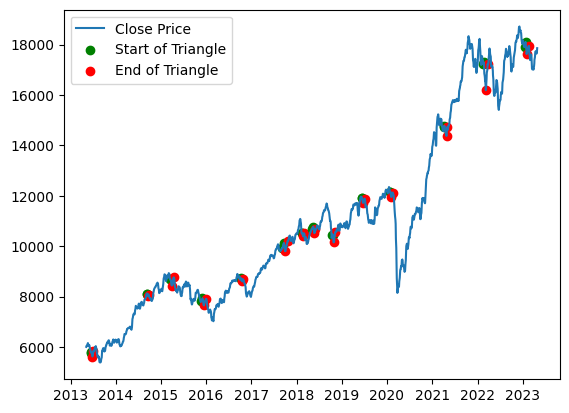

In [14]:
flags, data = ascending_triangle(data_NSE.Close, 0.01)
plt.plot(data.index, data)

for x in flags:
    plt.scatter(x[0:2], data[x[0:2]], color='green')
    plt.scatter(x[2:], data[x[2:]], color='red')
plt.legend(["Close Price", "Start of Triangle", "End of Triangle"])